# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 1



**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

**WARNING**: There is web page scraping in this homework. It takes about 40 minutes. **Do not wait till the last minute** to do this homework.

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. There is an important CAVEAT to this. DO NOT run the web-page fetching cells again. (We have provided hints like `# DO NOT RERUN THIS CELL WHEN SUBMITTING` on some of the cells where we provide the code). Instead load your data structures from the JSON files we will ask you to save below. Otherwise you will be waiting for a long time. (Another reason to not wait until the last moment to submit.)

- Do not include your name in the notebook.

---

# Homework 1: Rihanna or Mariah?

Billboard Magazine puts out a top 100 list of "singles" every week. Information from this list, as well as that from music sales, radio, and other sources is used to determine a top-100 "singles" of the year list. A **single** is typically one song, but sometimes can be two songs which are on one "single" record.

In this homework you will: 

1. Scrape Wikipedia to obtain infprmation about the best singers and groups from each year (distinguishing between the two groups) as determined by the Billboard top 100 charts. You will have to clean this data. Along the way you will learn how to save data in json files to avoid repeated scraping. 
2. Scrape Wikipedia to obtain information on these singers. You will have to scrape the web pages, this time using a cache to guard against network timeouts (or your laptop going to sleep). You will again clean the data, and save it to a json file.
3. Use pandas to represent these two datasets and merge them.
4. Use the individual and merged datasets to visualize the performance of the artists and their songs. We have kept the amount of analysis limited here for reasons of time; but you might enjoy exploring music genres and other aspects of the music business you can find on these wikipedia pages at your own leisure.

You should have worked through Lab0 and Lab 1, and Lecture 2.  Lab 2 will help as well.

As usual, first we import the necessary libraries.  In particular, we use [Seaborn](http://stanford.edu/~mwaskom/software/seaborn/) to give us a nicer default color palette, with our plots being of large (`poster`) size and with a white-grid background. 

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

## Q1. Scraping Wikipedia for Billboard Top 100.

In this question you will scrape Wikipedia for the Billboard's top 100 singles.

### Scraping Wikipedia for Billboard singles

We'll be using  [BeautifulSoup](http://www.crummy.com/software/BeautifulSoup/), and suggest that you use Python's built in `requests` library to fetch the web page.

In [2]:
import requests
from bs4 import BeautifulSoup
req = requests.get(" http://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_1970")
page = req.text
soup = BeautifulSoup(page, 'html.parser')

#### 1.1 Parsing the Billboard Wikipedia page for 1970

In [3]:
tables_wikitable = soup.find_all("table", "wikitable")
len(tables_wikitable)

1

In [4]:
rows = [row for row in tables_wikitable[0].find_all("tr")]
header_row = rows[0]
header_row
columns = [col.get_text() for col in header_row.find_all("th") if col.get_text()]
columns

['№', 'Title', 'Artist(s)']

In [5]:
values = []
for row in rows[1:]:
    count = 0
    d_1 = dict()
    for td in row.find_all("td"):
        count += 1
        text = td.get_text()
        if count == 1:
            rank = int(text)
            d_1['ranking'] = rank
        elif count == 2:
            song_url_list = []
            for link in td.find_all("a"):
                song_url_list.append(link.get("href"))
            if "/" in text:
                songs = text.split("/")
                d_1['title'] = songs
            else:
                d_1['title'] = text
            d_1['songurl'] = song_url_list
        elif count == 3:
            artist_url_list = []
            for link in td.find_all("a"):
                artist_url_list.append(link.get("href"))
            if "featuring" and "and" in text:
                text = "Kanye featuring TPain and Taylor Swift"
                text1 = text.split(" featuring ")
                #text1 = ["Kanye", "TPain and Taylor Swift"]
                text2 = text1[1].split(" and ")
                #text2 = ["TPain", "Taylor Swift"]
                text = text2.insert(0, text1[0])
            elif "featuring" in text:
                text = text.split(" featuring ")
            d_1['band_singer'] = text
            d_1['url'] = artist_url_list
            values.append(d_1)
            d_1 = dict()
values

[{'band_singer': 'Simon & Garfunkel',
  'ranking': 1,
  'songurl': ['/wiki/Bridge_over_Troubled_Water_(song)'],
  'title': '"Bridge over Troubled Water"',
  'url': ['/wiki/Simon_%26_Garfunkel']},
 {'band_singer': 'The Carpenters',
  'ranking': 2,
  'songurl': ['/wiki/(They_Long_to_Be)_Close_to_You'],
  'title': '"(They Long to Be) Close to You"',
  'url': ['/wiki/The_Carpenters']},
 {'band_singer': 'The Guess Who',
  'ranking': 3,
  'songurl': ['/wiki/American_Woman'],
  'title': '"American Woman"',
  'url': ['/wiki/The_Guess_Who']},
 {'band_singer': 'B.J. Thomas',
  'ranking': 4,
  'songurl': ['/wiki/Raindrops_Keep_Fallin%27_on_My_Head'],
  'title': '"Raindrops Keep Fallin\' on My Head"',
  'url': ['/wiki/B.J._Thomas']},
 {'band_singer': 'Edwin Starr',
  'ranking': 5,
  'songurl': ['/wiki/War_(The_Temptations_song)#Edwin_Starr_version'],
  'title': '"War"',
  'url': ['/wiki/Edwin_Starr']},
 {'band_singer': 'Diana Ross',
  'ranking': 6,
  'songurl': ['/wiki/Ain%27t_No_Mountain_High_Eno

Obtain the web page at http://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_1970 using a HTTP GET request. From this web page we'll extract the top 100 singles and their rankings. Create a list of dictionaries, 100 of them to be precise, with entries like 

`{'url': '/wiki/Sugarloaf_(band)', 'ranking': 30, 'band_singer': 'Sugarloaf', 'title': 'Green-Eyed Lady'}`. 

If you look at that web page, you'll see a link for every song, from which you can get the `url` of the singer or band. We will use these links later to scrape information about the singer or band. From the listing we can also get the band or singer name `band_singer`, and `title` of the song.

*HINT: look for a table with class `wikitable`.*

You should get something similar to this (where songs is the aforementioned list):

```
songs[2:4]
```

```
[{'band_singer': 'The Guess Who',
  'ranking': 3,
  'title': '"American Woman"',
  'url': '/wiki/The_Guess_Who'},
 {'band_singer': 'B.J. Thomas',
  'ranking': 4,
  'title': '"Raindrops Keep Fallin\' on My Head"',
  'url': '/wiki/B.J._Thomas'}]
```

#### 1.2 Generalize the previous: scrape Wikipedia from 1992 to 2014

In [ ]:
import time
start = 1992
yearstext = dict()
for i in range(23):
    year = str(start + i)
    req = requests.get(" http://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_" + year)
    page = req.text
    soup = BeautifulSoup(page, 'html.parser')
    yearstext[int(year)] = soup
    time.sleep(12)
yearstext

By visiting the urls similar to the ones for 1970, we can obtain the billboard top 100 for the years 1992 to 2014. (We choose these later years rather than 1970 as you might find music from this era more interesting.) Download these using Python's `requests` module and store the text from those requests in a dictionary called `yearstext`. This dictionary ought to have as its keys the years (as integers from 1992 to 2014), and as values corresponding to these keys the text of the page being fetched.

You ought to sleep a second (look up `time.sleep` in Python) at the very least in-between fetching each web page: you do not want Wikipedia to think you are a marauding bot attempting to mount a denial-of-service attack.

*HINT: you might find `range` and string-interpolation useful to construct the URLs *.


#### 1.3 Parse and Clean data 

Remember the code you wrote to get data from 1970 which produces a list of dictionaries, one corresponding to each single.  Now write a function `parse_year(the_year, yeartext_dict)` which takes the year, prints it out, gets the text for the year from the just created `yearstext` dictionary, and return a list of dictionaries for that year, with one dictionary for each single. Store this list in the variable `yearinfo`.

The dictionaries **must** be of this form:

```
{'band_singer': ['Brandy', 'Monica'],
  'ranking': 2,
  'song': ['The Boy Is Mine'],
  'songurl': ['/wiki/The_Boy_Is_Mine_(song)'],
  'titletext': '" The Boy Is Mine "',
  'url': ['/wiki/Brandy_Norwood', '/wiki/Monica_(entertainer)']}
```

The spec of this function is provided below:

In [ ]:
"""
Function
--------
parse_year

Inputs
------
the_year: the year you want the singles for
yeartext_dict: a dictionary with keys as integer years and values the downloaded web pages 
    from wikipedia for that year.
   
Returns
-------

a list of dictionaries, each of which corresponds to a single and has the
following data:

Eg:

{'band_singer': ['Brandy', 'Monica'],
  'ranking': 2,
  'song': ['The Boy Is Mine'],
  'songurl': ['/wiki/The_Boy_Is_Mine_(song)'],
  'titletext': '" The Boy Is Mine "',
  'url': ['/wiki/Brandy_Norwood', '/wiki/Monica_(entertainer)']}
  
A dictionary with the following data:
    band_singer: a list of bands/singers who made this single
    song: a list of the titles of songs on this single
    songurl: a list of the same size as song which has urls for the songs on the single 
        (see point 3 above)
    ranking: ranking of the single
    titletext: the contents of the table cell
    band_singer: a list of bands or singers on this single
    url: a list of wikipedia singer/band urls on this single: only put in the part 
        of the url from /wiki onwards
    

Notes
-----
See description and example above.
"""

In [6]:
def parse_year(the_year, year_dict):
    full_page = year_dict.get(the_year)
    tables_wikitable = full_page.find_all("table", "wikitable")
    rows = [row for row in tables_wikitable[0].find_all("tr")]
    values = []
    for row in rows[1:]:
        count = 0
        d_1 = dict()
        for td in row.find_all("td"):
            count += 1
            text = td.get_text()
            th = row.find("th")
            rank = int(th.get_text())
            d_1['ranking'] = rank
            if count == 1:
                song_url_list = []
                for link in td.find_all("a"):
                    song_url_list.append(link.get("href"))
                if "/" in text:
                    songs = text.split("/")
                    d_1['titletext'] = songs
                else:
                    d_1['titletext'] = text
                if len(song_url_list) == 0:
                    song_url_list.append(None)
                d_1['songurl'] = song_url_list
            elif count == 2:
                artist_url_list = []
                for link in td.find_all("a"):
                    artist_url_list.append(link.get("href"))
                if "featuring" in text and "and" in text:
                    text1 = text.split(" featuring ")
                    #text1 = ["Kanye", "TPain and Taylor Swift"]
                    text2 = text1[1].split(" and ")
                    #text2 = ["TPain", "Taylor Swift"]
                    text2.insert(0, text1[0])
                    text = text2
                elif "featuring" in text and len(artist_url_list) > 1:
                    text = text.split(" featuring ")
                elif "and" in text and len(artist_url_list) > 1:
                    text = text.split(" and ")
                elif "&" in text and len(artist_url_list) > 1:
                    text = text.split(" & ")
                d_1['band_singer'] = text
                d_1['url'] = artist_url_list
                values.append(d_1)
                d_1 = dict()
    return values
parse_year(1997, yearstext)[:5]


NameError: name 'yearstext' is not defined

In [ ]:
yearinfo = {k: parse_year(k, yearstext) for k, v in yearstext.items()}

#### Helpful notes

Notice that some singles might have multiple songs:

```
{'band_singer': ['Jewel'],
  'ranking': 2,
  'song': ['Foolish Games', 'You Were Meant for Me'],
  'songurl': ['/wiki/Foolish_Games',
   '/wiki/You_Were_Meant_for_Me_(Jewel_song)'],
  'titletext': '" Foolish Games " / " You Were Meant for Me "',
  'url': ['/wiki/Jewel_(singer)']}
```

And some singles don't have a song URL:

```
{'band_singer': [u'Nu Flavor'],
  'ranking': 91,
  'song': [u'Heaven'],
  'songurl': [None],
  'titletext': u'"Heaven"',
  'url': [u'/wiki/Nu_Flavor']}
```

Thus there are some issues this function must handle:

1. There can be more than one  `band_singer` as can be seen above (sometimes with a comma, sometimes with "featuring" in between). The best way to parse these is to look for the urls.
2. There can be two songs in a single, because of the way the industry works: there are two-sided singles. See https://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_1997 for an example. You can find other examples in 1998 and 1999.
3. The `titletext` is the contents of the table cell, and retains the quotes that Wikipedia puts on the single.
4. If no song anchor is found (see the 24th song in the above url), assume there is one song in the single, set `songurl` to [`None`] and the song name to the contents of the table cell with the quotes stripped (ie `song` is a one-element list with this the `titletext` stripped of its quotes).

As a check, we can do this for 1997. We'll print the first 5 outputs: `parse_year(1997, yearstext)[:5]`

This should give the following. Notice that the year 1997 exercises the edge cases we talked about earlier.

```
[{'band_singer': ['Elton John'],
  'ranking': 1,
  'song': ['Something About the Way You Look Tonight',
   'Candle in the Wind 1997'],
  'songurl': ['/wiki/Something_About_the_Way_You_Look_Tonight',
   '/wiki/Candle_in_the_Wind_1997'],
  'titletext': '" Something About the Way You Look Tonight " / " Candle in the Wind 1997 "',
  'url': ['/wiki/Elton_John']},
 {'band_singer': ['Jewel'],
  'ranking': 2,
  'song': ['Foolish Games', 'You Were Meant for Me'],
  'songurl': ['/wiki/Foolish_Games',
   '/wiki/You_Were_Meant_for_Me_(Jewel_song)'],
  'titletext': '" Foolish Games " / " You Were Meant for Me "',
  'url': ['/wiki/Jewel_(singer)']},
 {'band_singer': ['Puff Daddy', 'Faith Evans', '112'],
  'ranking': 3,
  'song': ["I'll Be Missing You"],
  'songurl': ['/wiki/I%27ll_Be_Missing_You'],
  'titletext': '" I\'ll Be Missing You "',
  'url': ['/wiki/Sean_Combs', '/wiki/Faith_Evans', '/wiki/112_(band)']},
 {'band_singer': ['Toni Braxton'],
  'ranking': 4,
  'song': ['Un-Break My Heart'],
  'songurl': ['/wiki/Un-Break_My_Heart'],
  'titletext': '" Un-Break My Heart "',
  'url': ['/wiki/Toni_Braxton']},
 {'band_singer': ['Puff Daddy', 'Mase'],
  'ranking': 5,
  'song': ["Can't Nobody Hold Me Down"],
  'songurl': ['/wiki/Can%27t_Nobody_Hold_Me_Down'],
  'titletext': '" Can\'t Nobody Hold Me Down "',
  'url': ['/wiki/Sean_Combs', '/wiki/Mase']}]
```

#### Save a json file of information from the scraped files

We do not want to lose all this work, so let's save the last data structure we created to disk. That way if you need to re-run from here, you don't need to redo all these requests and parsing. 

DO NOT RERUN THE HTTP REQUESTS TO WIKIPEDIA WHEN SUBMITTING.

*We **DO NOT** need to see these JSON files in your submission!*

In [8]:
import json

In [ ]:
# DO NOT RERUN THIS CELL WHEN SUBMITTING
fd = open("data/yearinfo.json","w")
json.dump(yearinfo, fd)
fd.close()
del yearinfo

Now let's reload our JSON file into the yearinfo variable, just to be sure everything is working.

In [9]:
# RERUN WHEN SUBMITTING
# Another way to deal with files. Has the advantage of closing the file for you.
with open("data/yearinfo.json", "r") as fd:
    yearinfo = json.load(fd)

#### 1.4 Construct a year-song-singer dataframe from the yearly information

In [10]:
temp_list = []
for key, value in yearinfo.items():
    temp = pd.DataFrame.from_dict(value)
    temp['year'] = key
    temp_list.append(temp)
flatframe = pd.concat(temp_list)
cols = flatframe.columns.tolist()
neworder = [5,0,1,2,3,4]
cols = [ cols[i] for i in neworder]
flatframe = flatframe[cols]
flatframe
    

,year,band_singer,ranking,songurl,titletext,url
0,1992,Boyz II Men,1,[/wiki/End_of_the_Road],"""End of the Road""",[/wiki/Boyz_II_Men]
1,1992,Sir Mix-a-Lot,2,[/wiki/Baby_Got_Back],"""Baby Got Back""",[/wiki/Sir_Mix-a-Lot]
2,1992,Kris Kross,3,[/wiki/Jump],"""Jump""",[/wiki/Kris_Kross]
3,1992,Vanessa Williams,4,[/wiki/Save_the_Best_for_Last],"""Save the Best for Last""",[/wiki/Vanessa_L._Williams]
4,1992,TLC,5,[/wiki/Baby-Baby-Baby],"""Baby-Baby-Baby""",[/wiki/TLC_(band)]
5,1992,Eric Clapton,6,[/wiki/Tears_in_Heaven],"""Tears in Heaven""",[/wiki/Eric_Clapton]
6,1992,En Vogue,7,[/wiki/My_Lovin%27_(You%27re_Never_Gonna_Get_It)],"""My Lovin' (You're Never Gonna Get It)""",[/wiki/En_Vogue]
7,1992,Red Hot Chili Peppers,8,[/wiki/Under_the_Bridge],"""Under the Bridge""",[/wiki/Red_Hot_Chili_Peppers]
8,1992,Color Me Badd,9,[/wiki/All_4_Love],"""All 4 Love""",[/wiki/Color_Me_Badd]
9,1992,Jon Secada,10,[/wiki/Just_Another_Day_(Jon_Secada_song)],"""Just Another Day""",[/wiki/Jon_Secada]


In [11]:
flatframe.dtypes

year           object
band_singer    object
ranking         int64
songurl        object
titletext      object
url            object
dtype: object

In [12]:
flatframe['year'] = flatframe['year'].astype(int)
flatframe.dtypes

year            int32
band_singer    object
ranking         int64
songurl        object
titletext      object
url            object
dtype: object

In [13]:
print(np.sum([flatframe.year.isnull()]))
print(np.sum([flatframe.band_singer.isnull()]))
print(np.sum([flatframe.ranking.isnull()]))
print(np.sum([flatframe.titletext.isnull()]))
print(np.sum([flatframe.songurl.isnull()]))
print(np.sum([flatframe.url.isnull()]))

0
0
0
0
0
0


Let's construct a dataframe `flatframe` from the `yearinfo`. The frame should be similar to the frame below.  Each row of the frame represents a song, and carries with it the chief properties of year, song, singer, and ranking.

![](https://raw.githubusercontent.com/cs109/a-2017/master/hwassets/images/HW1SC1.png)

To construct the dataframe, we'll need to iterate over the years and the singles per year. Notice how, above, the dataframe is ordered by ranking and then year. While the exact order is up to you, note that you will have to come up with a scheme to order the information.

Check that the dataframe has sensible data types. You will also likely find that the year field has become an "object" (Pandas treats strings as generic objects): this is due to the conversion to and back from JSON. Such conversions need special care. Fix any data type issues with `flatframe`. (See Pandas [astype](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.astype.html) function.) 
We will use this `flatframe` in the next question. 

(As an aside, we used the name `flatframe` to indicate that this dataframe is flattened from a hierarchical dictionary structure with the keys being the years.)

### Who are the highest quality singers?

Here we show the highest quality singers and plot them on a bar chart.

#### 1.5 Find highest quality singers according to how prolific they are

What do we mean by highest quality? This is of course open to interpretation, but let's define "highest quality" here as the number of times a singer appears in the top 100 over this time period. If a singer appears twice in a year (for different songs), this is counted as two appearances, not one. 

Make a bar-plot of the most prolific singers. Singers on this chart should have appeared at-least more than 15 times. (HINT: look at the docs for the pandas method `value_counts`.)


In [14]:
rows = []
for i, row in flatframe.iterrows():
    if isinstance(row.band_singer, list):
        if isinstance(row.url, list) and len(row.url) == len(row.band_singer):
            index = 0
            for a in row.band_singer:
                rows.append([row.year, a, row.ranking, row.songurl, row.titletext, row.url[index]])
                index += 1
        elif isinstance(row.url, list):
            for a in row.band_singer:
                rows.append([row.year, a, row.ranking, row.songurl, row.titletext, row.url[0]])
        else:
            for a in row.band_singer:
                rows.append([row.year, a, row.ranking, row.songurl, row.titletext, None])
    elif len(row.url) != 0:
        rows.append([row.year, row.band_singer, row.ranking, row.songurl, row.titletext, row.url[0]])
    else:
        rows.append([row.year, row.band_singer, row.ranking, row.songurl, row.titletext, None])

        
flatframe = pd.DataFrame(rows, columns = cols)
flatframe

,year,band_singer,ranking,songurl,titletext,url
0,1992,Boyz II Men,1,[/wiki/End_of_the_Road],"""End of the Road""",/wiki/Boyz_II_Men
1,1992,Sir Mix-a-Lot,2,[/wiki/Baby_Got_Back],"""Baby Got Back""",/wiki/Sir_Mix-a-Lot
2,1992,Kris Kross,3,[/wiki/Jump],"""Jump""",/wiki/Kris_Kross
3,1992,Vanessa Williams,4,[/wiki/Save_the_Best_for_Last],"""Save the Best for Last""",/wiki/Vanessa_L._Williams
4,1992,TLC,5,[/wiki/Baby-Baby-Baby],"""Baby-Baby-Baby""",/wiki/TLC_(band)
5,1992,Eric Clapton,6,[/wiki/Tears_in_Heaven],"""Tears in Heaven""",/wiki/Eric_Clapton
6,1992,En Vogue,7,[/wiki/My_Lovin%27_(You%27re_Never_Gonna_Get_It)],"""My Lovin' (You're Never Gonna Get It)""",/wiki/En_Vogue
7,1992,Red Hot Chili Peppers,8,[/wiki/Under_the_Bridge],"""Under the Bridge""",/wiki/Red_Hot_Chili_Peppers
8,1992,Color Me Badd,9,[/wiki/All_4_Love],"""All 4 Love""",/wiki/Color_Me_Badd
9,1992,Jon Secada,10,[/wiki/Just_Another_Day_(Jon_Secada_song)],"""Just Another Day""",/wiki/Jon_Secada


In [15]:
counts = flatframe.band_singer.value_counts()
counts_15 = counts[counts > 15]
counts_15

Rihanna                35
Usher                  29
R. Kelly               28
Lil Wayne              28
Ludacris               27
Mariah Carey           26
Chris Brown            24
Jay-Z                  23
T-Pain                 22
Eminem                 21
Drake                  20
Justin Timberlake      20
Beyoncé                20
Pink                   19
Kanye West             19
T.I.                   18
Akon                   18
Britney Spears         17
Alicia Keys            17
Taylor Swift           17
Kelly Clarkson         17
Katy Perry             17
The Black Eyed Peas    16
Madonna                16
Name: band_singer, dtype: int64

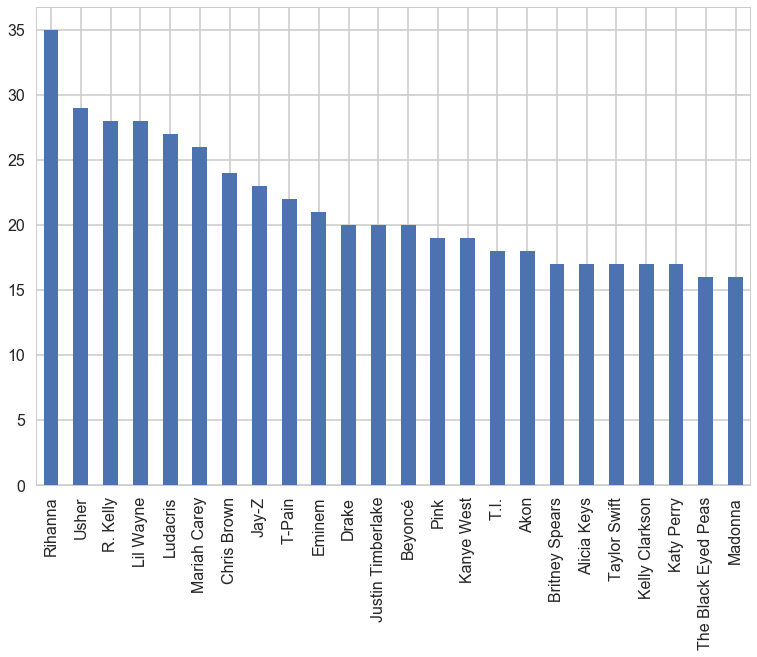

In [16]:
counts_15.plot.bar()

#### 1.6 What if we used a different metric?

What we would like to capture is this: a singer should to be scored higher if the singer appears higher in the rankings. So we'd say that a singer who appeared once at a higher and once at a lower ranking is a "higher quality" singer than one who appeared twice at a lower ranking. 

To do this, group all of a singers songs together and assign each song a score `101 - ranking`. Order the singers by their total score and make a bar chart for the top 20.


In [17]:
scores = flatframe['ranking'].apply(lambda x: 101 - x)
flatframe['score'] = scores
flatframe

,year,band_singer,ranking,songurl,titletext,url,score
0,1992,Boyz II Men,1,[/wiki/End_of_the_Road],"""End of the Road""",/wiki/Boyz_II_Men,100
1,1992,Sir Mix-a-Lot,2,[/wiki/Baby_Got_Back],"""Baby Got Back""",/wiki/Sir_Mix-a-Lot,99
2,1992,Kris Kross,3,[/wiki/Jump],"""Jump""",/wiki/Kris_Kross,98
3,1992,Vanessa Williams,4,[/wiki/Save_the_Best_for_Last],"""Save the Best for Last""",/wiki/Vanessa_L._Williams,97
4,1992,TLC,5,[/wiki/Baby-Baby-Baby],"""Baby-Baby-Baby""",/wiki/TLC_(band),96
5,1992,Eric Clapton,6,[/wiki/Tears_in_Heaven],"""Tears in Heaven""",/wiki/Eric_Clapton,95
6,1992,En Vogue,7,[/wiki/My_Lovin%27_(You%27re_Never_Gonna_Get_It)],"""My Lovin' (You're Never Gonna Get It)""",/wiki/En_Vogue,94
7,1992,Red Hot Chili Peppers,8,[/wiki/Under_the_Bridge],"""Under the Bridge""",/wiki/Red_Hot_Chili_Peppers,93
8,1992,Color Me Badd,9,[/wiki/All_4_Love],"""All 4 Love""",/wiki/Color_Me_Badd,92
9,1992,Jon Secada,10,[/wiki/Just_Another_Day_(Jon_Secada_song)],"""Just Another Day""",/wiki/Jon_Secada,91


In [18]:
artist_scores = flatframe['score'].groupby(flatframe['band_singer']).sum()
artist_scores = artist_scores.sort_values(ascending = False)
artist_scores_20 = artist_scores[:20]
artist_scores_20

band_singer
Rihanna              2103
Usher                1834
Mariah Carey         1727
Lil Wayne            1428
Ludacris             1361
Katy Perry           1264
Jay-Z                1258
Justin Timberlake    1191
Chris Brown          1166
Beyoncé              1160
Pink                 1141
Kanye West           1133
Akon                 1041
R. Kelly             1023
Alicia Keys          1010
50 Cent               982
Bruno Mars            972
Nelly                 957
Maroon 5              957
Janet Jackson         952
Name: score, dtype: int64

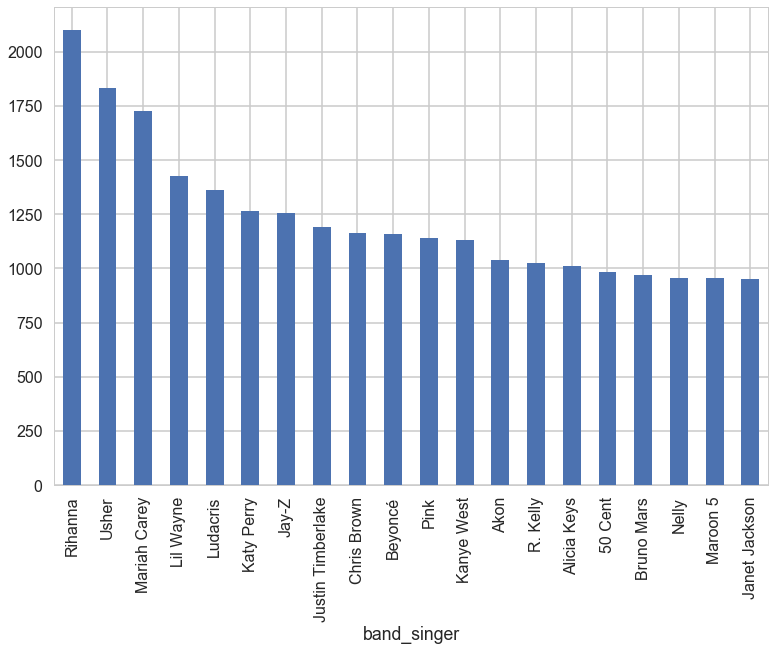

In [19]:
artist_scores_20.plot.bar()

#### 1.7 Do you notice any major differences when you change the metric?

How have the singers at the top shifted places? Why do you think this happens?

The most significant difference that I noticed, was the position of Katy Perry, who went from being pretty far behind the top artists in 18th place, to 6th place. Also, Mariah Carey's position improved by two spots on the second chart, where she holds a fairly large margin over Lil Wayne. I think that these artists shifted places because some of them, like Katy Perry and Mariah Carey, play pop music that has a much more general appeal than some other artists. So they might not show up on the charts as often, because they aren't as prolific as other artists, but when they do show up, they usually take a very high spot.

## Q2. Scraping and Constructing: Information about Artists, Bands and Genres from Wikipedia

Our next job is to use those band/singer urls we collected under `flatframe.url` and get information about singers and/or bands.

### Scrape information about artists from wikipedia

We wish to fetch information about the singers or groups for all the winning songs in a list of years.

Here we show a function that fetches information about a singer or group from their url on wikipedia. We create a cache object `urlcache` that will avoid redundant HTTP requests (e.g. an artist might have multiple singles on a single year, or be on the list over a span of years). Once we have fetched information about an artist, we don't need to do it again. The caching also helps if the network goes down, or the target website is having some problems. You simply need to run the `get_page` function below again, and the `urlcache` dictionary will continue to be filled.

If the request gets an HTTP return code different from 200, (such as a 404 not found or 500 Internal Server Error) the cells for that URL will have a value of 1; and if the request completely fails (e.g. no network connection) the cell will have a value of 2. This will allow you to analyse the failed requests.

Notice that we have wrapped the call in whats called _an exception block_. We try to make the request. If it fails entirely, or returns a HTTP code thats not 200, we set the status to 2 and 1 respectively.

In [ ]:
urlcache={}


In [ ]:
def get_page(url):
    # Check if URL has already been visited.
    if (url not in urlcache) or (urlcache[url]==1) or (urlcache[url]==2):
        time.sleep(1)
        # try/except blocks are used whenever the code could generate an exception (e.g. division by zero).
        # In this case we don't know if the page really exists, or even if it does, if we'll be able to reach it.
        try:
            r = requests.get("http://en.wikipedia.org%s" % url)

            if r.status_code == 200:
                urlcache[url] = r.text
            else:
                urlcache[url] = 1
        except:
            urlcache[url] = 2
    return urlcache[url]


We sort the `flatframe` by year, ascending, first. Think why.

In [ ]:
flatframe=flatframe.sort_values('year')
flatframe.head()

#### Pulling and saving the data

In [ ]:
# DO NOT RERUN THIS CELL WHEN SUBMITTING
# Here we are populating the url cache
# subsequent calls to this cell should be very fast, since Python won't
# need to fetch the page from the web server.
# NOTE this function will take quite some time to run (about 30 mins for me), since we sleep 1 second before
# making a request. If you run it again it will be almost instantaneous, save requests that might have failed
# (you will need to run it again if requests fail..see cell below for how to test this)
flatframe["url"].apply(get_page)

You may have to run this function again and again, in case there were network problems. Note that, because there is a "global" cache, it will take less time each time you run it. Also note that this function is designed to be run again and again: it attempts to make sure that there are no unresolved pages remaining. Let us make sure of this: *the sum below should be 0, and the boolean True.*

In [ ]:
# DO NOT RERUN THIS CELL WHEN SUBMITTING
print("Number of bad requests:",np.sum([(urlcache[k]==1) or (urlcache[k]==2) for k in urlcache])) # no one or 0's)
print("Did we get all urls?", len(flatframe.url.unique())==len(urlcache)) # we got all of the urls

Let's save the `urlcache` to disk, just in case we need it again.

In [ ]:
# DO NOT RERUN THIS CELL WHEN SUBMITTING
with open("data/artistinfo.json","w") as fd:
    json.dump(urlcache, fd)
del urlcache

In [20]:
# RERUN WHEN SUBMITTING
with open("data/artistinfo.json") as json_file:
    urlcache = json.load(json_file)

#### 2.1 Extract information about singers and bands

From each page we collected about a singer or a band, extract the following information:

1. If the page has the text "Born" in the sidebar on the right, extract the element with the class `.bday`. If the page doesn't contain "Born", store `False`.  Store either of these into the variable `born`. We want to analyze the artist's age.

2. If the text "Years active" is found, but no "born", assume a band. Store into the variable `ya` the value of the next table cell corresponding to this, or `False` if the text is not found.

Put this all into a function `singer_band_info` which takes the singer/band url as argument and returns a dictionary `dict(url=url, born=born, ya=ya)`.

The information can be found on the sidebar on each such wikipedia page, as the example here shows:

![sandg](https://raw.githubusercontent.com/cs109/a-2017/master/hwassets/images/sandg.png).



In [21]:
def singer_band_info(url, page_text):
    if type(page_text) != str:
        return dict()
    soup = BeautifulSoup(page_text, 'html.parser')
    dict_1 = dict()
    infobox = soup.find('table', 'infobox')
    if infobox == None:
        return dict_1
    born = ''
    ya = ''
    for tr in infobox.find_all('tr'):
        for th in tr.find_all('th'):
            if 'Years' in th.get_text():
                ya_i = tr.td.get_text()
                ya = ya_i.replace('\n', ', ').strip()
            elif "Born" in th.get_text():
                bday = tr.td.find('span', 'bday')
                if bday != None:
                    born = bday.get_text()
    if born == '':
        born = False
    dict_1['url'] = url
    dict_1['born'] = born
    dict_1['ya'] = ya
    return dict_1                

            

singer_band_info('/wiki/Jay_Z', urlcache.get('/wiki/Jay_Z'))


{'born': '1969-12-04', 'url': '/wiki/Jay_Z', 'ya': '1986–present'}

Write the function `singer_band_info` according to the following specification:

In [ ]:
"""
Function
--------
singer_band_info

Inputs
------
url: the url
page_text: the text associated with the url
   
Returns
-------
A dictionary with the following data:
    url: copy the input argument url into this value
    born: the artist's birthday
    ya: years active variable

Notes
-----
See description above. Also note that some of the genres urls might require a 
bit of care and special handling.
"""

#### 2.2  Merging this information in

In [22]:
singer_band_info_list = []
for url, text in urlcache.items():
    singer_band_info_list.append(singer_band_info(url, text))
singer_band_info_list[-10:]


[{'born': False, 'url': '/wiki/MKTO', 'ya': '2010 – 2017'},
 {'born': False, 'url': '/wiki/Clean_Bandit', 'ya': '2008–present'},
 {'born': '1989-10-20', 'url': '/wiki/Jess_Glynne', 'ya': '2012–present'},
 {'born': '1986-04-01', 'url': '/wiki/Kid_Ink', 'ya': '2010–present'},
 {'born': '1979-01-07', 'url': '/wiki/Aloe_Blacc', 'ya': '1995–present'},
 {'born': False, 'url': '/wiki/Gente_de_Zona', 'ya': '2000–present'},
 {'born': '1971-07-05', 'url': '/wiki/Descemer_Bueno', 'ya': '1990–present'},
 {'born': False, 'url': '/wiki/American_Authors', 'ya': '2006–present'},
 {'born': '1987-10-29', 'url': '/wiki/Tove_Lo', 'ya': '2006–present'},
 {'born': '1990-11-26', 'url': '/wiki/Rita_Ora', 'ya': '2007–present'}]

In [23]:
info_df = pd.DataFrame(singer_band_info_list)
info_df

,born,url,ya
0,False,/wiki/Boyz_II_Men,1985–present
1,False,/wiki/Ugly_Kid_Joe,", , , 1987–1997, 2010–present, , ,"
2,False,/wiki/The_Cure,1976–present
3,1959-11-05,/wiki/Bryan_Adams,1975–present
4,False,/wiki/Marky_Mark_and_the_Funky_Bunch,1989–1993
5,False,/wiki/Genesis_(band),", , , 1967–1998[4][5], 2006–2007, , ,"
6,False,/wiki/Arrested_Development_(group),"1988–1996, 2000–present"
7,1958-08-29,/wiki/Michael_Jackson,1964–2009
8,False,/wiki/Kris_Kross,"1991–2002, 2013 (reunion)"
9,1951-04-13,/wiki/Peabo_Bryson,1976–present


In [30]:
largedf = pd.merge(flatframe, info_df, on='url')
largedf

,year,band_singer,ranking,songurl,titletext,url,score,born,ya
0,1992,Boyz II Men,1,[/wiki/End_of_the_Road],"""End of the Road""",/wiki/Boyz_II_Men,100,False,1985–present
1,1992,Boyz II Men,37,[/wiki/It%27s_So_Hard_to_Say_Goodbye_to_Yester...,"""It's So Hard to Say Goodbye to Yesterday""",/wiki/Boyz_II_Men,64,False,1985–present
2,1992,Boyz II Men,84,[/wiki/Uhh_Ahh],"""Uhh Ahh""",/wiki/Boyz_II_Men,17,False,1985–present
3,1993,Boyz II Men,12,[/wiki/In_the_Still_of_the_Night_(1956_song)#B...,"""In the Still of the Nite""",/wiki/Boyz_II_Men,89,False,1985–present
4,1994,Boyz II Men,3,[/wiki/I%27ll_Make_Love_to_You],"""I'll Make Love to You""",/wiki/Boyz_II_Men,98,False,1985–present
5,1995,Boyz II Men,5,[/wiki/On_Bended_Knee],"""On Bended Knee""",/wiki/Boyz_II_Men,96,False,1985–present
6,1995,Boyz II Men,12,[/wiki/Water_Runs_Dry],"""Water Runs Dry""",/wiki/Boyz_II_Men,89,False,1985–present
7,1995,Boyz II Men,50,[/wiki/I%27ll_Make_Love_to_You],"""I'll Make Love to You""",/wiki/Boyz_II_Men,51,False,1985–present
8,1995,Boyz II Men,94,[/wiki/Thank_You_(Boyz_II_Men_song)],"""Thank You""",/wiki/Boyz_II_Men,7,False,1985–present
9,1996,Boyz II Men,2,[/wiki/One_Sweet_Day],"""One Sweet Day""",/wiki/Boyz_II_Men,99,False,1985–present


Iterate over the items in the singer-group dictionary cache `urlcache`, run the above function, and create a dataframe from there with columns `url`, `born`, and `ya`. Merge this dataframe on the `url` key with `flatframe`, creating a rather wide dataframe that we shall call `largedf`. It should look something like this:

![](https://raw.githubusercontent.com/cs109/a-2017/master/hwassets/images/HW1SC3.png)

Notice how the `born` and `ya` and `url` are repeated every time a different song from a given band is represented in a row.

#### 2.3 What is the age at which singers achieve their top ranking?

In [25]:
for index, row in largedf.iterrows():
       if row.born == False:
            largedf = largedf.drop(index)
        
largedf = largedf[pd.notnull(largedf['born'])]
largedf.isnull().sum()

year           0
band_singer    0
ranking        0
songurl        0
titletext      0
url            0
score          0
born           0
ya             0
dtype: int64

In [26]:
#first reduce so that each artist is only in once for their best ranking
idx = largedf.groupby(['band_singer'])['ranking'].transform(min) == largedf['ranking']
rank_highest_loc = largedf[idx]
rank_highest_loc

,year,band_singer,ranking,songurl,titletext,url,score,born,ya
13,1992,Sir Mix-a-Lot,2,[/wiki/Baby_Got_Back],"""Baby Got Back""",/wiki/Sir_Mix-a-Lot,99,1963-08-12,"1983–2003, 2010–Present"
18,1992,Vanessa Williams,4,[/wiki/Save_the_Best_for_Last],"""Save the Best for Last""",/wiki/Vanessa_L._Williams,97,1963-03-18,1982–present
32,1992,Eric Clapton,6,[/wiki/Tears_in_Heaven],"""Tears in Heaven""",/wiki/Eric_Clapton,95,1945-03-30,1962–present
50,1992,Jon Secada,10,[/wiki/Just_Another_Day_(Jon_Secada_song)],"""Just Another Day""",/wiki/Jon_Secada,91,1961-10-04,1984–present
54,1992,Shanice,11,[/wiki/I_Love_Your_Smile],"""I Love Your Smile""",/wiki/Shanice,90,1973-05-14,1984–present
59,1992,Michael Jackson,14,[/wiki/Black_or_White],"""Black or White""",/wiki/Michael_Jackson,87,1958-08-29,1964–2009
67,1992,Billy Ray Cyrus,15,[/wiki/Achy_Breaky_Heart],"""Achy Breaky Heart""",/wiki/Billy_Ray_Cyrus,86,1961-08-25,1989–present
87,2005,Mariah Carey,1,[/wiki/We_Belong_Together_(Mariah_Carey_song)],"""We Belong Together""",/wiki/Mariah_Carey,100,1969-03-27,1988–present
95,1992,Tom Cochrane,18,[/wiki/Life_Is_a_Highway],"""Life Is a Highway""",/wiki/Tom_Cochrane,83,1953-05-14,1973–present
96,1992,CeCe Peniston,20,[/wiki/Finally_(CeCe_Peniston_song)],"""Finally""",/wiki/CeCe_Peniston,81,1969-09-06,1991–present


In [27]:
#change 'born' so that it is just the year and an int
rank_highest_loc['born'] = rank_highest_loc['born'].apply(lambda x: int(x[:4]))
rank_highest_loc

C:\Users\charl\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,year,band_singer,ranking,songurl,titletext,url,score,born,ya
13,1992,Sir Mix-a-Lot,2,[/wiki/Baby_Got_Back],"""Baby Got Back""",/wiki/Sir_Mix-a-Lot,99,1963,"1983–2003, 2010–Present"
18,1992,Vanessa Williams,4,[/wiki/Save_the_Best_for_Last],"""Save the Best for Last""",/wiki/Vanessa_L._Williams,97,1963,1982–present
32,1992,Eric Clapton,6,[/wiki/Tears_in_Heaven],"""Tears in Heaven""",/wiki/Eric_Clapton,95,1945,1962–present
50,1992,Jon Secada,10,[/wiki/Just_Another_Day_(Jon_Secada_song)],"""Just Another Day""",/wiki/Jon_Secada,91,1961,1984–present
54,1992,Shanice,11,[/wiki/I_Love_Your_Smile],"""I Love Your Smile""",/wiki/Shanice,90,1973,1984–present
59,1992,Michael Jackson,14,[/wiki/Black_or_White],"""Black or White""",/wiki/Michael_Jackson,87,1958,1964–2009
67,1992,Billy Ray Cyrus,15,[/wiki/Achy_Breaky_Heart],"""Achy Breaky Heart""",/wiki/Billy_Ray_Cyrus,86,1961,1989–present
87,2005,Mariah Carey,1,[/wiki/We_Belong_Together_(Mariah_Carey_song)],"""We Belong Together""",/wiki/Mariah_Carey,100,1969,1988–present
95,1992,Tom Cochrane,18,[/wiki/Life_Is_a_Highway],"""Life Is a Highway""",/wiki/Tom_Cochrane,83,1953,1973–present
96,1992,CeCe Peniston,20,[/wiki/Finally_(CeCe_Peniston_song)],"""Finally""",/wiki/CeCe_Peniston,81,1969,1991–present


In [28]:
#create new column for the artist's age at the time the song is on the billboard hot 100
rank_highest_loc['age_at_song'] = rank_highest_loc.apply(lambda x: x['year'] - x['born'], axis=1)
rank_highest_loc

C:\Users\charl\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,year,band_singer,ranking,songurl,titletext,url,score,born,ya,age_at_song
13,1992,Sir Mix-a-Lot,2,[/wiki/Baby_Got_Back],"""Baby Got Back""",/wiki/Sir_Mix-a-Lot,99,1963,"1983–2003, 2010–Present",29
18,1992,Vanessa Williams,4,[/wiki/Save_the_Best_for_Last],"""Save the Best for Last""",/wiki/Vanessa_L._Williams,97,1963,1982–present,29
32,1992,Eric Clapton,6,[/wiki/Tears_in_Heaven],"""Tears in Heaven""",/wiki/Eric_Clapton,95,1945,1962–present,47
50,1992,Jon Secada,10,[/wiki/Just_Another_Day_(Jon_Secada_song)],"""Just Another Day""",/wiki/Jon_Secada,91,1961,1984–present,31
54,1992,Shanice,11,[/wiki/I_Love_Your_Smile],"""I Love Your Smile""",/wiki/Shanice,90,1973,1984–present,19
59,1992,Michael Jackson,14,[/wiki/Black_or_White],"""Black or White""",/wiki/Michael_Jackson,87,1958,1964–2009,34
67,1992,Billy Ray Cyrus,15,[/wiki/Achy_Breaky_Heart],"""Achy Breaky Heart""",/wiki/Billy_Ray_Cyrus,86,1961,1989–present,31
87,2005,Mariah Carey,1,[/wiki/We_Belong_Together_(Mariah_Carey_song)],"""We Belong Together""",/wiki/Mariah_Carey,100,1969,1988–present,36
95,1992,Tom Cochrane,18,[/wiki/Life_Is_a_Highway],"""Life Is a Highway""",/wiki/Tom_Cochrane,83,1953,1973–present,39
96,1992,CeCe Peniston,20,[/wiki/Finally_(CeCe_Peniston_song)],"""Finally""",/wiki/CeCe_Peniston,81,1969,1991–present,23


(array([  12.,  131.,  235.,  184.,   56.,   32.,    6.,    9.,    2.,    1.]),
 array([ 12. ,  17.8,  23.6,  29.4,  35.2,  41. ,  46.8,  52.6,  58.4,
         64.2,  70. ]),
 <a list of 10 Patch objects>)

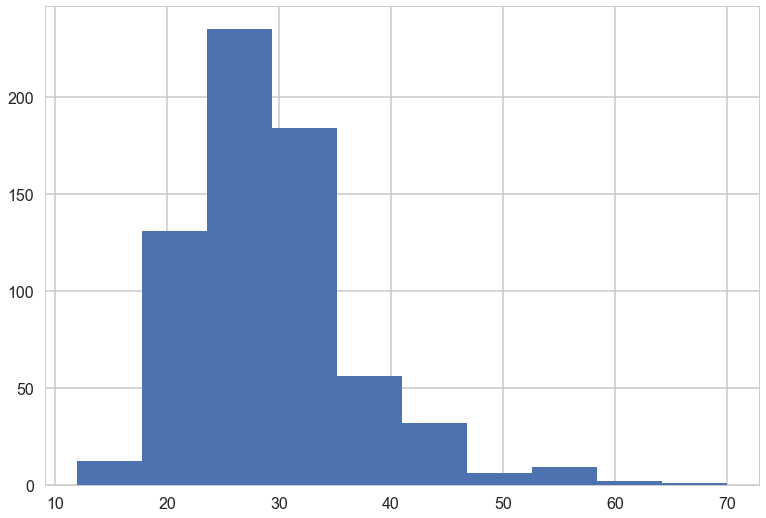

In [29]:
#now use that to plot the frequency of certain ages at the artist's highest rank
plt.hist(rank_highest_loc['age_at_song'])


Plot a histogram of the age at which singers achieve their top ranking. What conclusions can you draw from this distribution of ages?

*HINT: You will need to do some manipulation of the `born` column, and find the song for which a band or an artist achieves their top ranking. You will then need to put these rows together into another dataframe or array to make the plot.*

It seems that the vast majority of singers reach the top 100 when they are young, which is what I would have expected.

#### 2.4 At what year since inception do bands reach their top rankings?

In [31]:
for index, row in largedf.iterrows():
       if row.born != False:
            largedf = largedf.drop(index)
        
largedf = largedf[pd.notnull(largedf['born'])]
largedf.isnull().sum()

year           0
band_singer    0
ranking        0
songurl        0
titletext      0
url            0
score          0
born           0
ya             0
dtype: int64

In [32]:
banddf = largedf
banddf['ya'] = banddf['ya'].apply(lambda x: x.replace(',', ''))
banddf['ya'] = banddf['ya'].apply(lambda x: x.strip())
for index, row in banddf.iterrows():
    if len(row.ya) < 4:
        banddf = banddf.drop(index)
banddf['inception'] = banddf['ya'].apply(lambda x: int(x[:4]))
banddf

,year,band_singer,ranking,songurl,titletext,url,score,born,ya,inception
0,1992,Boyz II Men,1,[/wiki/End_of_the_Road],"""End of the Road""",/wiki/Boyz_II_Men,100,False,1985–present,1985
1,1992,Boyz II Men,37,[/wiki/It%27s_So_Hard_to_Say_Goodbye_to_Yester...,"""It's So Hard to Say Goodbye to Yesterday""",/wiki/Boyz_II_Men,64,False,1985–present,1985
2,1992,Boyz II Men,84,[/wiki/Uhh_Ahh],"""Uhh Ahh""",/wiki/Boyz_II_Men,17,False,1985–present,1985
3,1993,Boyz II Men,12,[/wiki/In_the_Still_of_the_Night_(1956_song)#B...,"""In the Still of the Nite""",/wiki/Boyz_II_Men,89,False,1985–present,1985
4,1994,Boyz II Men,3,[/wiki/I%27ll_Make_Love_to_You],"""I'll Make Love to You""",/wiki/Boyz_II_Men,98,False,1985–present,1985
5,1995,Boyz II Men,5,[/wiki/On_Bended_Knee],"""On Bended Knee""",/wiki/Boyz_II_Men,96,False,1985–present,1985
6,1995,Boyz II Men,12,[/wiki/Water_Runs_Dry],"""Water Runs Dry""",/wiki/Boyz_II_Men,89,False,1985–present,1985
7,1995,Boyz II Men,50,[/wiki/I%27ll_Make_Love_to_You],"""I'll Make Love to You""",/wiki/Boyz_II_Men,51,False,1985–present,1985
8,1995,Boyz II Men,94,[/wiki/Thank_You_(Boyz_II_Men_song)],"""Thank You""",/wiki/Boyz_II_Men,7,False,1985–present,1985
9,1996,Boyz II Men,2,[/wiki/One_Sweet_Day],"""One Sweet Day""",/wiki/Boyz_II_Men,99,False,1985–present,1985


In [33]:
idx = banddf.groupby(['band_singer'])['ranking'].transform(min) == banddf['ranking']
best_baddf = banddf[idx]
banddf

,year,band_singer,ranking,songurl,titletext,url,score,born,ya,inception
0,1992,Boyz II Men,1,[/wiki/End_of_the_Road],"""End of the Road""",/wiki/Boyz_II_Men,100,False,1985–present,1985
1,1992,Boyz II Men,37,[/wiki/It%27s_So_Hard_to_Say_Goodbye_to_Yester...,"""It's So Hard to Say Goodbye to Yesterday""",/wiki/Boyz_II_Men,64,False,1985–present,1985
2,1992,Boyz II Men,84,[/wiki/Uhh_Ahh],"""Uhh Ahh""",/wiki/Boyz_II_Men,17,False,1985–present,1985
3,1993,Boyz II Men,12,[/wiki/In_the_Still_of_the_Night_(1956_song)#B...,"""In the Still of the Nite""",/wiki/Boyz_II_Men,89,False,1985–present,1985
4,1994,Boyz II Men,3,[/wiki/I%27ll_Make_Love_to_You],"""I'll Make Love to You""",/wiki/Boyz_II_Men,98,False,1985–present,1985
5,1995,Boyz II Men,5,[/wiki/On_Bended_Knee],"""On Bended Knee""",/wiki/Boyz_II_Men,96,False,1985–present,1985
6,1995,Boyz II Men,12,[/wiki/Water_Runs_Dry],"""Water Runs Dry""",/wiki/Boyz_II_Men,89,False,1985–present,1985
7,1995,Boyz II Men,50,[/wiki/I%27ll_Make_Love_to_You],"""I'll Make Love to You""",/wiki/Boyz_II_Men,51,False,1985–present,1985
8,1995,Boyz II Men,94,[/wiki/Thank_You_(Boyz_II_Men_song)],"""Thank You""",/wiki/Boyz_II_Men,7,False,1985–present,1985
9,1996,Boyz II Men,2,[/wiki/One_Sweet_Day],"""One Sweet Day""",/wiki/Boyz_II_Men,99,False,1985–present,1985


Make a similar calculation to plot a histogram of the years since inception at which bands reach their top ranking. What conclusions can you draw?